# Merging, Storing, and Visualizing DataFrames

**1. NFL Games Data 1970-2016.xlsx**   
**2. NFL Season Stats Data 1970-2016.xlsx**   
**3. NFL Game Weather Data.xlsx**  
    - I reduced the data set because abbreviation to team name and location mapping is still needed for some of the older teams. Furthermore, the webdata that was scraped from PFF only included NFL team stats and not AFL team stats from before the merger, so I was missing some team stats.  
    - Some manual edits and checks were made in Excel, especially for teams like the Chargers, Rams, Raiders, Cardinals, and Colts, who have moved their franchises multiple times.
    - NFL Games Data 1970-2016 / NFL Game Weather Data Common Keys: date + game location
    - NFL Games Data 1970-2016 / NFL Season Stats Data 1970-2016 Common Keys: season + home full and season + away full

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
pd.set_option('display.max_columns', None)

## Merging DataFrames

In [2]:
games_df = pd.read_excel('NFL Games Data 1970-2016.xlsx')
stats_df = pd.read_excel('NFL Season Stats Data 1970-2016.xlsx')
weather_df = pd.read_excel('NFL Game Weather Data.xlsx')

In [3]:
# Renaming columns to make stats refer to home or away team for each game
stats_columns = stats_df.columns
home_dict = {}
away_dict = {}
for stat in stats_columns:
    new_home_stat = 'home ' + stat
    new_away_stat = 'away ' + stat
    home_dict.update({stat:new_home_stat})
    away_dict.update({stat:new_away_stat})
home_stats_df = stats_df.rename(columns = home_dict)
away_stats_df = stats_df.rename(columns = away_dict)

In [4]:
# Merge games games_df (game results) with stats_df (team season stats)
merged_df = pd.merge(games_df, home_stats_df, how = 'left', left_on=['season','home full'],
                     right_on = ['home year','home team'])
merged_df = pd.merge(merged_df, away_stats_df, how = 'left', left_on=['season','away full'],
                     right_on = ['away year','away team'])

# Delete redundant columns
merged_df.drop(['home year', 'home team', 'away year', 'away team'], axis=1, inplace = True)

# Merge weather data
merged_df = pd.merge(merged_df, weather_df, how = 'left', left_on=['date','game location'],
                     right_on = ['Date time','Address'])
# Delete redundant columns
merged_df.drop(['Date time','Address'], axis=1, inplace = True)

merged_df

,date,season,game location,playoff,home,away,home elo,away elo,home elo prob,home score,away score,winner,loser,home full,away full,home location,away location,home nickname,away nickname,stadium type,home wins,home losses,home ties,home win loss perc,home points,home points opp,home points diff,home mov,home sos total,home srs total,home srs offense,home srs defense,away wins,away losses,away ties,away win loss perc,away points,away points opp,away points diff,away mov,away sos total,away srs total,away srs offense,away srs defense,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,Resolved Address,Name,Info,Conditions
0,1970-09-18,1970,Los Angeles,0,LAR,ARI,1583.202000,1426.127000,0.782172,34,13,LAR,ARI,Los Angeles Rams,St. Louis Cardinals,Los Angeles,Saint Louis Missouri,Rams,Cardinals,outdoor,9,4,1,0.692,325,202,123,8.8,0.8,9.6,4.4,5.3,8,5,1,0.615,325,228,97,6.9,0.5,7.4,3.8,3.6,59.3,72.9,66.0,57.2,74.16,0.0,13.1,0.0,266.00,0.0,0.0,0.00,0.0,3.1,291.4,1013.8,"Fog, Smoke Or Haze",34.05361,-118.24550,"Los Angeles, CA, United States",NaN,NaN,Overcast
1,1970-09-19,1970,East Rutherford,0,NYG,CHI,1475.119000,1382.173000,0.712839,16,24,CHI,NYG,New York Giants,Chicago Bears,East Rutherford,Chicago,Giants,Bears,outdoor,9,5,0,0.643,301,270,31,2.2,-0.2,2.0,1.9,0.1,6,8,0,0.429,256,261,-5,-0.4,2.6,2.2,0.4,1.8,65.2,74.9,71.5,54.1,54.88,0.0,13.9,0.0,264.92,0.0,0.0,0.00,0.0,14.8,294.7,1020.6,NaN,40.83455,-74.09835,"East Rutherford, NJ, United States",NaN,NaN,Overcast
2,1970-09-20,1970,San Diego,0,LAC,IND,1522.059000,1586.888000,0.500246,14,16,IND,LAC,San Diego Chargers,Baltimore Colts,San Diego,Baltimore,Chargers,Colts,outdoor,5,6,3,0.455,282,278,4,0.3,-1.0,-0.7,0.5,-1.2,11,2,1,0.846,321,234,87,6.2,-5.8,0.4,0.9,-0.5,63.9,71.2,67.8,58.8,73.51,0.0,10.4,0.0,246.17,0.0,0.0,0.00,0.0,10.6,292.6,1012.3,NaN,32.71568,-117.16171,"San Diego, CA, United States",NaN,NaN,Overcast
3,1970-09-20,1970,Cincinnati,0,CIN,OAK,1396.972000,1638.776000,0.265463,31,21,CIN,OAK,Cincinnati Bengals,Oakland Raiders,Cincinnati,Oakland,Bengals,Raiders,outdoor,8,6,0,0.571,312,255,57,4.1,-3.5,0.5,1.2,-0.6,8,4,2,0.667,300,293,7,0.5,0.5,1.0,2.3,-1.3,68.1,86.9,78.7,65.8,65.47,88.3,11.6,0.0,224.00,0.0,0.0,0.00,0.0,7.1,298.2,1016.8,"Fog, Smoke Or Haze",39.10713,-84.50413,"Cincinnati, OH, United States",NaN,NaN,Overcast
4,1970-09-20,1970,San Francisco,0,SF,WAS,1458.876000,1488.866000,0.550214,26,17,SF,WAS,San Francisco 49ers,Washington Redskins,San Francisco,Washington,49ers,Redskins,outdoor,10,3,1,0.769,352,267,85,6.1,0.4,6.5,6.4,0.1,6,8,0,0.429,297,314,-17,-1.2,4.2,3.0,3.6,-0.6,55.1,70.1,62.1,51.9,70.88,0.0,21.9,0.0,252.00,0.0,0.0,0.00,0.0,10.8,289.5,1016.8,Fog,37.77713,-122.41964,"San Francisco, CA, United States",NaN,NaN,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11186,2017-01-15,2016,Dallas,1,DAL,GB,1617.794683,1635.451172,0.567714,31,34,GB,DAL,Dallas Cowboys,Green Bay Packers,Dallas,Green Bay,Cowboys,Packers,indoor,13,3,0,0.813,421,306,115,7.2,-0.2,7.0,4.1,2.9,10,6,0,0.625,432,388,44,2.8,0.1,2.8,4.9,-2.0,52.0,65.9,59.9,58.1,93.85,0.0,30.9,51.3,134.67,0.0,1.1,66.67,0.0,3.9,87.4,1013.3,"Lightning Without Thunder, Mist, Light Drizzle...",32.77823,-96.79512,"Dallas, TX, United States",NaN,NaN,"Rain, Overcast"
11187,2017-01-15,2016,Kansas City,1,KC,PIT,1681.926463,1647.734179,0.638993,16,18,PIT,KC,Kansas City Chiefs,Pittsburgh Steelers,Kansas City,Pittsburgh,Chiefs,Steelers,outdoor,12,4,0,0.750,389,311,78,4.9,0.7,5.6,1.2,4.4,11,5,0,0.688,399,327,72,4.5,0.2,4.7,2.8,2.0,32.1,33.2,33.1,30.9,91.79,0.0,10.3,0.0,71.67,25.0,0.0,66.67,0.0,3.3,91.6,1023

In [5]:
# Saved to a separate Excel file
merged_df.to_excel('NFL_Games_Stats_Wx_Data.xlsx', sheet_name='data')

## Storing Data in a Database

In [6]:
engine = create_engine('sqlite:///NFL_Games_Stats_Wx_Data.db', echo=True)
sqlite_connection = engine.connect()

2020-05-30 10:20:29,813 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-05-30 10:20:29,832 INFO sqlalchemy.engine.base.Engine ()
2020-05-30 10:20:29,832 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-05-30 10:20:29,832 INFO sqlalchemy.engine.base.Engine ()


In [7]:
sqlite_table = 'NFL_Games'
merged_df.to_sql(sqlite_table, sqlite_connection, if_exists='fail')

2020-05-30 10:20:29,928 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("NFL_Games")
2020-05-30 10:20:29,930 INFO sqlalchemy.engine.base.Engine ()
2020-05-30 10:20:29,932 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("NFL_Games")
2020-05-30 10:20:29,934 INFO sqlalchemy.engine.base.Engine ()
2020-05-30 10:20:29,952 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE "NFL_Games" (
	"index" BIGINT, 
	date DATETIME, 
	season BIGINT, 
	"game location" TEXT, 
	playoff BIGINT, 
	home TEXT, 
	away TEXT, 
	"home elo" FLOAT, 
	"away elo" FLOAT, 
	"home elo prob" FLOAT, 
	"home score" BIGINT, 
	"away score" BIGINT, 
	winner TEXT, 
	loser TEXT, 
	"home full" TEXT, 
	"away full" TEXT, 
	"home location" TEXT, 
	"away location" TEXT, 
	"home nickname" TEXT, 
	"away nickname" TEXT, 
	"stadium type" TEXT, 
	"home wins" BIGINT, 
	"home losses" BIGINT, 
	"home ties" BIGINT, 
	"home win loss perc" FLOAT, 
	"home points" BIGINT, 
	"home points opp" BIGINT, 
	"home points diff" BIGINT, 
	

2020-05-30 10:20:33,626 INFO sqlalchemy.engine.base.Engine COMMIT
2020-05-30 10:20:33,986 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-05-30 10:20:33,986 INFO sqlalchemy.engine.base.Engine ()


In [8]:
# Double checking everything made it over to the Database
with sqlite3.connect('NFL_Games_Stats_Wx_Data.db') as conn:
    cursor = conn.execute('SELECT * FROM NFL_Games LIMIT 2')
    for row in cursor.fetchall():
        print(row)
    cursor = conn.execute('SELECT * FROM NFL_Games')
    print('-'*50)
    print('Rows in Database: {}'.format(len(cursor.fetchall())))
    print('Rows in Pandas DataFrame: {}'.format(merged_df.shape[0]))


(0, '1970-09-18 00:00:00.000000', 1970, 'Los Angeles', 0, 'LAR', 'ARI', 1583.202, 1426.127, 0.7821715840000001, 34, 13, 'LAR', 'ARI', 'Los Angeles Rams', 'St. Louis Cardinals', 'Los Angeles', 'Saint Louis Missouri', 'Rams', 'Cardinals', 'outdoor', 9, 4, 1, 0.6920000000000001, 325, 202, 123, 8.8, 0.8, 9.6, 4.4, 5.3, 8, 5, 1, 0.615, 325, 228, 97, 6.9, 0.5, 7.4, 3.8, 3.6, 59.3, 72.9, 66.0, 57.2, 74.16, 0.0, 13.1, 0.0, 266.0, 0.0, 0.0, 0.0, 0.0, 3.1, 291.4, 1013.8, 'Fog, Smoke Or Haze', 34.05361, -118.2455, 'Los Angeles, CA, United States', None, None, 'Overcast')
(1, '1970-09-19 00:00:00.000000', 1970, 'East Rutherford', 0, 'NYG', 'CHI', 1475.119, 1382.173, 0.7128385309999999, 16, 24, 'CHI', 'NYG', 'New York Giants', 'Chicago Bears', 'East Rutherford', 'Chicago', 'Giants', 'Bears', 'outdoor', 9, 5, 0, 0.643, 301, 270, 31, 2.2, -0.2, 2.0, 1.9, 0.1, 6, 8, 0, 0.429, 256, 261, -5, -0.4, 2.6, 2.2, 0.4, 1.8, 65.2, 74.9, 71.5, 54.1, 54.88, 0.0, 13.9, 0.0, 264.92, 0.0, 0.0, 0.0, 0.0, 14.8, 294.7,

In [9]:
sqlite_connection.close()

## Visualizations

In [10]:
# Importing visualization packages
import matplotlib
from plotnine import *
%matplotlib inline

In [13]:
# Getting df showing average/overall winning percentage and home winning percentage
home_wins = merged_df[merged_df['home']==merged_df['winner']].groupby(['home nickname']).size()
home_games = merged_df.groupby(['home nickname']).size()
home_winning_perc = home_wins / home_games
average_winning_perc = merged_df.groupby(['home nickname']).mean()['home win loss perc']
win_perc_data = pd.concat([home_winning_perc, average_winning_perc],
                          keys=['home winning percentage', 'total winning percentage'], axis=1).reset_index()

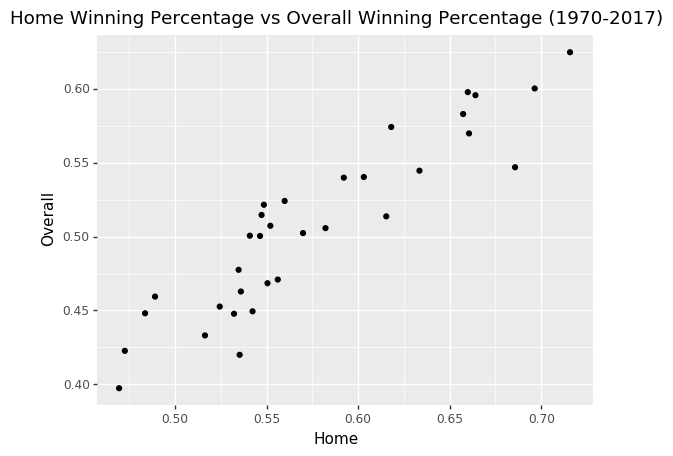

<ggplot: (-9223371910240468524)>

In [14]:
# Plot using data from games flat file (home winning percentage) and season stats scraped web data (avg winning perc)
(ggplot(win_perc_data)+
aes(x='home winning percentage', y='total winning percentage')+
geom_point()+
labs(title='Home Winning Percentage vs Overall Winning Percentage (1970-2017)',
    x = 'Home', y = 'Overall')
)

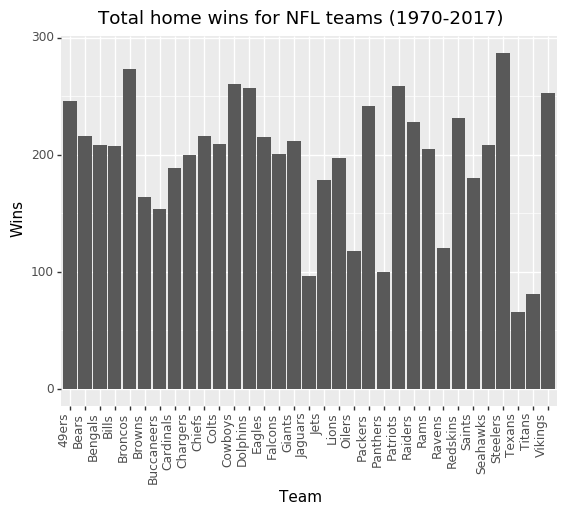

<ggplot: (-9223371910239950296)>

In [15]:
# Plot using games flat file data (total home wins)
home_wins_2 = pd.DataFrame(home_wins).reset_index()
home_wins_2.rename(columns={'home nickname':'team', 0:'wins'}, inplace = True)
(ggplot(home_wins_2, aes(x='team', y='wins'))+
geom_col()+
theme(axis_text_x=element_text(rotation=90, hjust=1))+
labs(title='Total home wins for NFL teams (1970-2017)',
    x = 'Team', y = 'Wins')
)

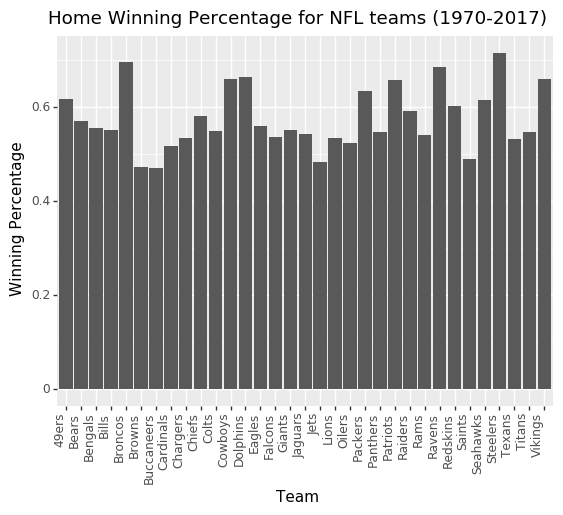

<ggplot: (-9223371910243505324)>

In [16]:
# Plot using games flat file data (home winning percentage)
home_win_perc = win_perc_data.drop('total winning percentage', axis=1)
home_win_perc = home_win_perc.rename(columns={'home nickname':'Team',
                                              'home winning percentage':'Winning Percentage'})
(ggplot(home_win_perc, aes(x='Team', y='Winning Percentage'))+
geom_col()+
theme(axis_text_x=element_text(rotation=90, hjust=1))+
labs(title='Home Winning Percentage for NFL teams (1970-2017)')
)

In [24]:
# Get counts of rain games for each team
rain_games = merged_df[merged_df['Weather Type'].str.contains('Rain',na=False)]
rain_games_home = rain_games.drop(rain_games.columns.difference(['home']), 1)
rain_games_away = rain_games.drop(rain_games.columns.difference(['away']), 1)
all_rain_games = pd.concat([rain_games_home.rename(columns={'home':'Team'}),
                            rain_games_away.rename(columns={'away':'Team'})])

# Get counts of windy games for each team
windy_games = merged_df[merged_df['Wind Speed']>14.8]
windy_games_home = windy_games.drop(windy_games.columns.difference(['home']), 1)
windy_games_away = windy_games.drop(windy_games.columns.difference(['away']), 1)
all_windy_games = pd.concat([windy_games_home.rename(columns={'home':'Team'}),
                            windy_games_away.rename(columns={'away':'Team'})])

# Get counts of snow games for each team
snow_games = merged_df[merged_df['Weather Type'].str.contains('Snow',na=False)]
snow_games_home = snow_games.drop(snow_games.columns.difference(['home']), 1)
snow_games_away = snow_games.drop(snow_games.columns.difference(['away']), 1)
all_snow_games = pd.concat([snow_games_home.rename(columns={'home':'Team'}),
                            snow_games_away.rename(columns={'away':'Team'})])

# Combined Counts
wx_games_counts = pd.DataFrame({'Snow': all_rain_games.groupby('Team').size(),
                              'Rain': all_windy_games.groupby('Team').size(),
                              'Windy': all_snow_games.groupby('Team').size()}).reset_index()

C:\Users\ssear\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


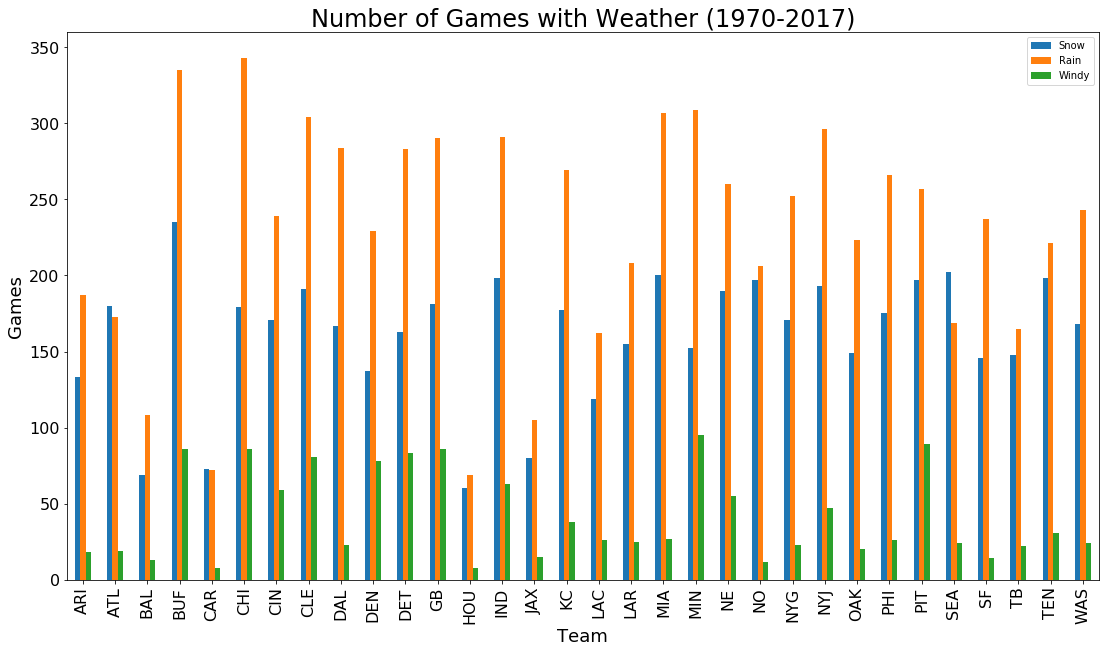

In [25]:
# Plot using weather data from API and flat file game data
wx_games_counts.plot(x='Team', y=['Snow', 'Rain', 'Windy'], kind='bar')
fig = matplotlib.pyplot.gcf()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Number of Games with Weather (1970-2017)', fontsize=24)
ax.set_xlabel('Team', fontsize=18)
ax.set_ylabel('Games', fontsize=18)
ax.tick_params(labelsize=16)
fig.set_size_inches(18.5, 10.5, forward=True)

In [92]:
# Getting groupby object for winning percentage of teams with offense srs > 5
home_team_good_offense = merged_df[merged_df['home srs offense']>5]
home_team_good_offense = home_team_good_offense.drop(home_team_good_offense.columns.difference(['home','winner']),1)
home_team_good_offense = home_team_good_offense.rename(columns={'home':'Team'})
away_team_good_offense = merged_df[merged_df['away srs offense']>5]
away_team_good_offense = away_team_good_offense.drop(away_team_good_offense.columns.difference(['away','winner']),1)
away_team_good_offense = away_team_good_offense.rename(columns={'away':'Team'})
all_good_offenses = pd.concat([home_team_good_offense, away_team_good_offense])
good_offense_wins = all_good_offenses[all_good_offenses['Team']==all_good_offenses['winner']].groupby(['Team']).size()
good_offense_win_pec = good_offense_wins/all_good_offenses.groupby(['Team']).size()

# Getting groupby object for winning percentage of teams with defense srs > 5
home_team_good_defense = merged_df[merged_df['home srs defense']>5]
home_team_good_defense = home_team_good_defense.drop(home_team_good_defense.columns.difference(['home','winner']),1)
home_team_good_defense = home_team_good_defense.rename(columns={'home':'Team'})
away_team_good_defense = merged_df[merged_df['away srs defense']>5]
away_team_good_defense = away_team_good_defense.drop(away_team_good_defense.columns.difference(['away','winner']),1)
away_team_good_defense = away_team_good_defense.rename(columns={'away':'Team'})
all_good_defense = pd.concat([home_team_good_defense, away_team_good_defense])
good_defense_wins = all_good_defense[all_good_defense['Team']==all_good_defense['winner']].groupby(['Team']).size()
good_defense_win_pec = good_defense_wins/all_good_defense.groupby(['Team']).size()

# Combining winning percentages into a single df
good_defense_offense = pd.DataFrame({'Defense': good_defense_wins/all_good_defense.groupby(['Team']).size(),
                                     'Offense': good_offense_wins/all_good_offenses.groupby(['Team']).size()}).reset_index()
good_defense_offense.rename(columns={'index':'Team'}, inplace=True)

C:\Users\ssear\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


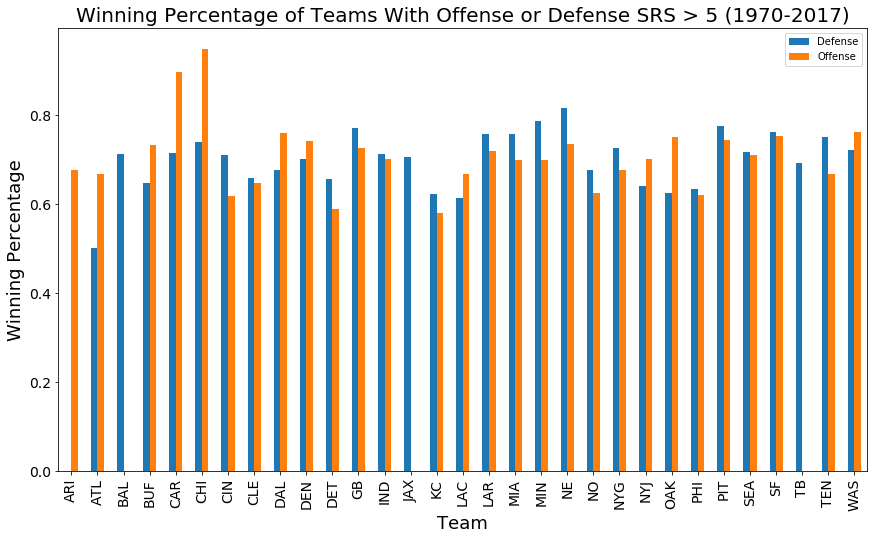

In [103]:
# Plot using season stats from web page and game results from flat file
good_defense_offense.plot(x='Team', y = ['Defense','Offense'], kind='bar')
fig = matplotlib.pyplot.gcf()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Winning Percentage of Teams With Offense or Defense SRS > 5 (1970-2017)', fontsize=20)
ax.set_xlabel('Team', fontsize=18)
ax.set_ylabel('Winning Percentage', fontsize=18)
ax.tick_params(labelsize=14)
fig.set_size_inches(14.5, 8.5, forward=True)